In [1]:
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple, Union, Optional, Generator
from math import ceil, floor, sqrt

## Setup

### Helper functions

In [3]:
def split_data(points: np.ndarray, labels: np.ndarray, train_size: Union[int, float], test_size: Union[int, float]):
    """Split data into train and test datasets
    """
    number_of_points = points.shape[0]

    if isinstance(train_size, float) and isinstance(test_size, float):
        if (train_size + test_size) != 1.0:
            raise ValueError(f"train size + test size should be equal to 1.0")

        train_size = ceil(train_size * number_of_points)
        test_size = floor(test_size * number_of_points)
    elif isinstance(train_size, int) and isinstance(test_size, int):
        if number_of_points != (train_size + test_size):
            raise ValueError(f"train size + test size should be equal to the number of points")
    else:
        raise TypeError("train_size and test_size should be the same type")

    splitted_points = np.split(points, [train_size, number_of_points], axis=0)[:-1]
    splitted_labels = np.split(labels, [train_size, number_of_points], axis=0)[:-1]
    return splitted_points + splitted_labels

def show_loss(train_loss: list, test_loss: list) -> None:
    epochs = list(range(1, len(train_loss) + 1))
    plt.figure()
    plt.title("Learning Curve", fontsize=14)
    plt.plot(epochs, train_loss, "ro", label = "train loss")
    plt.plot(epochs, test_loss, "bo", label = "validation loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def show_accuracy(train_accuracy: list, test_accuracy: list) -> None:
    epochs = list(range(1, len(train_accuracy) + 1))
    plt.figure()
    plt.title("Train Accuracy vs Validation Accuracy", fontsize=14)
    plt.plot(epochs, train_accuracy, "ro", label = "train accuracy")
    plt.plot(epochs, test_accuracy, "bo", label = "validation accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

### Data

In [4]:
class Data:
    _DATA_RANDOM_SEED: int = 8765
    _data_random_generator: np.random.Generator = np.random.default_rng(seed=5678)

    # deterministic random generator for data
    @classmethod
    def get_data_random_generator(cls, deterministic: bool = True) -> np.random.Generator:
        if deterministic:
            return np.random.default_rng(seed=cls._DATA_RANDOM_SEED)
        else:
            return cls._data_random_generator

    @classmethod
    def generate_uniform_data(cls, n: int):
        points = cls.get_data_random_generator().uniform(low=0.0, high=1.0, size=(n, 2))
        labels = np.fromiter(map(lambda point: int(point[0] <= point[1]), points), dtype=int)
        return points, np.expand_dims(labels, axis=-1)

    @classmethod
    def generate_X_like_data(cls, n: int = 11):
        points = []
        labels = []
        for value in np.linspace(0, 1, n):
            # value = 0.1 * i
            points.append([value, value])
            labels.append(0)

            if value == 1 - value:
                continue

            points.append([value, 1 - value])
            labels.append(1)
        return np.array(points, dtype=float), np.expand_dims(np.array(labels, dtype=int), axis=-1)

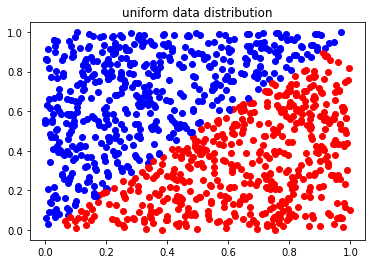

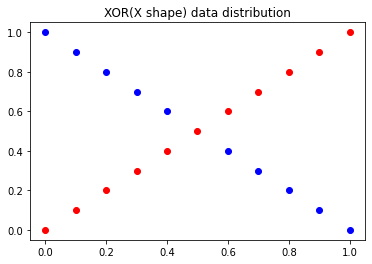

In [5]:
points, labels = Data.generate_uniform_data(1000)
plt.figure()
plt.title("uniform data distribution")
for i, point in enumerate(points):
    color = "bo" if labels[i] == 1 else "ro"
    plt.plot(point[0], point[1], color)
plt.show()

points, labels = Data.generate_X_like_data(n = 11)
plt.figure()
plt.title("XOR(X shape) data distribution")
for i, point in enumerate(points):
    color = "bo" if labels[i] == 1 else "ro"
    plt.plot(point[0], point[1], color)
plt.show()

### Optimizers

In [6]:
class Optimizer:
    def reset(self) -> None:
        pass

    def step(self, parameter: np.ndarray, gradient: np.ndarray) -> None:
        pass

class SGD(Optimizer):
    _learning_rate: float

    def __init__(self, learning_rate: float):
        self._learning_rate = learning_rate

    def step(self, parameter: np.ndarray, gradient: np.ndarray) -> None:
        parameter -= self._learning_rate * gradient

class Momentum(Optimizer):
    _learning_rate: float
    _momentum: float

    _velocity: List[np.ndarray]
    _current_velocity_index: int

    def __init__(self, learning_rate: float, momentum: float = 0.9) -> None:
        self._learning_rate = learning_rate
        self._momentum = momentum
        self._velocity = []
        self.reset()

    def reset(self) -> None:
        self._current_velocity_index = 0

    def step(self, parameter: np.ndarray, gradient: np.ndarray) -> None:
        if len(self._velocity) == self._current_velocity_index:
            self._velocity.append(np.zeros_like(gradient))

        velocity = self._velocity[self._current_velocity_index]
        velocity = self._momentum * velocity - self._learning_rate * gradient
        self._velocity[self._current_velocity_index] = velocity
        self._current_velocity_index += 1

        parameter += velocity

### Loss functions

In [7]:
def calculate_MSE_loss(y_pred: np.ndarray, y_true: np.ndarray):
    loss = np.mean((y_pred - y_true) ** 2.0)
    gradient = 2.0 * (y_pred - y_true) / y_pred.shape[0]
    return loss, gradient

def calculate_NLL_loss(y_pred: np.ndarray, y_true: np.ndarray):
    loss = -np.mean((y_true * np.log(y_pred)) + ((1.0 - y_true) * np.log(1.0 - y_pred)))
    gradient = -1 * ((y_true * 1.0 / y_pred) - ((1.0 - y_true) * 1.0 / (1.0 - y_pred))) / y_pred.shape[0]
    return loss, gradient

### Network components

In [8]:
class Module:
    def reset_parameters(self) -> None:
        pass

    def forward(self, x: np.ndarray) -> np.ndarray:
        return None

    def backward(self, g: np.ndarray) -> np.ndarray:
        return None

    def update(self, optimizer: Optimizer) -> None:
        pass

    def weight(self) -> np.ndarray:
        return None

    def bias(self) -> np.ndarray:
        return None

class Sigmoid(Module):
    _output: np.ndarray

    def __init__(self) -> None:
        super(Sigmoid, self).__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self._output = 1.0 / (1.0 + np.exp(-x))
        return self._output

    def backward(self, g: np.ndarray) -> np.ndarray:
        return g * self._output * (1.0 - self._output)

    def __str__(self) -> str:
        return "Sigmoid\n" \
            + "shape of activation: *"

class ReLU(Module):
    _input: np.ndarray

    def __init__(self) -> None:
        super(ReLU, self).__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self._input = x
        return np.maximum(0.0, x)

    def backward(self, g: np.ndarray) -> np.ndarray:
        return g * np.heaviside(self._input, 0.0)

    def __str__(self) -> str:
        return "ReLU\n" \
            + "shape of activation: *"

class LeakyReLU(Module):
    _input: np.ndarray
    _a: float

    def __init__(self, a: float = 0.01) -> None:
        super(LeakyReLU, self).__init__()
        self._a = a

    def forward(self, x: np.ndarray) -> np.ndarray:
        self._input = x
        return np.maximum(0.0, x) + self._a * np.minimum(0.0, x)

    def backward(self, g: np.ndarray) -> np.ndarray:
        tmp = self._input.copy()
        tmp[tmp >= 0.0] = 1.0
        tmp[tmp < 0.0] = self._a
        return g * tmp

    def __str__(self) -> str:
        return "LeakyReLU\n" \
            + "shape of activation: *"

class Tanh(Module):
    _output: np.ndarray

    def __init__(self) -> None:
        super(Tanh, self).__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self._output = np.tanh(x)
        return self._output

    def backward(self, g: np.ndarray) -> np.ndarray:
        return g * (1 - self._output ** 2)

    def __str__(self) -> str:
        return "Tanh\n" \
            + "shape of activation: *"

In [9]:
class Dense(Module):
    _random_generator: np.random.Generator
    _input_feature_size: int
    _output_feature_size: int
    _weight: np.ndarray
    _bias: np.ndarray
    _gradient_weight: np.ndarray
    _gradient_bias: np.ndarray
    _initializer: str

    _input: np.ndarray

    def __init__(self, input_feature_size: int, output_feature_size: int, bias: bool = True, initializer: str = "uniform", random_generator: np.random.Generator = np.random.default_rng()) -> None:
        super(Dense, self).__init__()
        self._random_generator = random_generator
        self._input_feature_size = input_feature_size
        self._output_feature_size = output_feature_size
        self._weight = np.zeros((input_feature_size, output_feature_size))
        if bias:
            self._bias = np.zeros(output_feature_size)
        else:
            self._bias = None

        self._initializer = initializer

    def reset_parameters(self) -> None:
        if self._initializer == "uniform":
            random_range = sqrt(1 / self._input_feature_size)
            self._weight = self._random_generator.uniform(low = -random_range, high = random_range, size = self._weight.shape)
            if self._bias is not None:
                self._bias = self._random_generator.uniform(low = -random_range, high = random_range, size = self._bias.shape)
        elif self._initializer == "normal":
            self._weight = self._random_generator.normal(loc = 0.0, scale = 1.0, size = self._weight.shape)
            if self._bias is not None:
                self._bias = self._random_generator.normal(loc = 0.0, scale = 1.0, size = self._bias.shape)
        else:
            raise NotImplementedError(f"The {self._initializer} initializer is not implemented.")

    def forward(self, x: np.ndarray) -> np.ndarray:
        self._input = x
        y = x @ self._weight
        if self._bias is not None:
            y += self._bias
        return y

    def backward(self, g: np.ndarray) -> np.ndarray:
        self._gradient_weight = self._input.T @ g
        if self._bias is not None:
            self._gradient_bias = np.mean(g, axis = 0)
        return g @ self._weight.T

    def update(self, optimizer: Optimizer) -> None:
        optimizer.step(self._weight, self._gradient_weight)
        if self._bias is not None:
            optimizer.step(self._bias, self._gradient_bias)

    def weight(self) -> np.ndarray:
        return self._weight

    def bias(self) -> np.ndarray:
        return self._bias

    def __str__(self) -> str:
        string = "Dense layer\n" \
            + f"shape of inputs: (*, {self._input_feature_size})\n" \
            + f"shape of outputs: (*, {self._output_feature_size})\n" \
            + f"shape of weights: {self._weight.shape}"
        if self._bias is not None:
            string += f"\nshape of bias: {self._bias.shape}"
        return string

In [10]:
class Model:
    _layers: List[Module]

    def predict(self, x: np.ndarray) -> np.ndarray:
        y = x
        for layer in self._layers:
            y = layer.forward(y)
        return y

    def backward(self, g: np.ndarray) -> np.ndarray:
        for i in range(len(self._layers) - 1, -1, -1):
            g = self._layers[i].backward(g)
        return None

    def update(self, optimizer: Optimizer) -> None:
        for layer in self._layers:
            layer.update(optimizer)

    def show_network(self) -> None:
        print("=" * 50)
        for i, layer in enumerate(self._layers):
            print(layer)
            if i != len(self._layers) - 1:
                print("-" * 50)
        print("=" * 50)

    def weights(self) -> Generator:
        for layer in self._layers:
            yield layer.weight()

    def bias(self) -> Generator:
        for layer in self._layers:
            yield layer.bias()

class UniformNetwork(Model):
    def __init__(self, 
        input_size: int,
        output_size: int,
        random_generator: np.random.Generator,
        initializer = "uniform",
        bias: bool = True,
        hidden_units: Union[List[dict], Tuple[dict]] = []
    ) -> None:
        super(UniformNetwork, self).__init__()
        self._layers = []

        # hidden layers
        for hidden_unit in hidden_units:
            hidden_size = hidden_unit["hidden_size"]
            layer = Dense(input_size, hidden_size, bias = hidden_unit["bias"], initializer = hidden_unit["initializer"], random_generator = random_generator)
            self._layers.extend([layer, ReLU()])
            input_size = hidden_size

        # output layer
        layer = Dense(input_size, output_size, bias = bias, initializer = initializer, random_generator = random_generator)
        self._layers.extend([layer, Sigmoid()])

        for layer in self._layers:
            layer.reset_parameters()

class XORNetwork(Model):
    def __init__(self, 
            input_size: int,
            output_size: int,
            random_generator: np.random.Generator,
            initializer = "uniform",
            bias: bool = True,
            hidden_units: Union[List[dict], Tuple[dict]] = []
        ) -> None:
        super(XORNetwork, self).__init__()
        self._layers = []

        # hidden layers
        for hidden_unit in hidden_units:
            hidden_size = hidden_unit["hidden_size"]
            layer = Dense(input_size, hidden_size, bias = hidden_unit["bias"], initializer = hidden_unit["initializer"], random_generator = random_generator)
            self._layers.extend([layer, ReLU()])
            input_size = hidden_size

        # output layer
        layer = Dense(input_size, output_size, bias = bias, initializer = initializer, random_generator = random_generator)
        self._layers.extend([layer, Sigmoid()])

        for layer in self._layers:
            layer.reset_parameters()

### Trainer

In [11]:
class Trainer:
    _model: Model
    _optimizer: Optimizer
    _epochs: int
    _early_stop: bool
    _early_stopping_times: int

    def __init__(self, model: Model, epochs: int, loss_func_name: str = "nll", optimizer: dict = {"name": "sgd", "learning_rate": 0.1}, early_stop: bool = False, early_stopping_times: int = 2):
        self._model = model
        self._epochs = epochs
        self._early_stop = early_stop
        self._early_stopping_times = early_stopping_times

        self._choose_optimizer(**optimizer)
        self._choose_loss_func(loss_func_name)

    def _round_results(self, y: np.ndarray) -> np.ndarray:
        return np.round(y)

    def _calculate_accuracy(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        return np.mean(self._round_results(y_pred) == y_true)

    def _shuffle_data(self, random_generator: np.random.Generator, x: np.ndarray, y: np.ndarray):
        data = list(zip(x, y))
        random_generator.shuffle(data, axis = 0)
        return list(map(np.array, zip(*data)))

    def _choose_optimizer(self, name: str, learning_rate: float, **kwargs):
        if name == "sgd":
            self._optimizer = SGD(learning_rate=learning_rate)
        elif name == "momentum":
            self._optimizer = Momentum(learning_rate=learning_rate, **kwargs)
        else:
            raise NotImplementedError(f"The {name} optimizer is not implemented.")

    def _choose_loss_func(self, name: str):
        if name == "nll":
            self._loss_func = calculate_NLL_loss
        elif name == "mse":
            self._loss_func = calculate_MSE_loss
        else:
            raise NotImplementedError(f"The {name} loss function is not implemented.")

    def train(self, x_train, x_val, y_train, y_val, shuffle: bool = True):
        loss_trains = []
        loss_vals = []
        accuracy_trains = []
        accuracy_vals = []
        times = 0

        shuffle_generator = np.random.default_rng(seed = 888)
        for epoch in range(1, self._epochs + 1):
            if shuffle:
                x_train, y_train = self._shuffle_data(shuffle_generator, x_train, y_train)

            y_pred = self._model.predict(x_train)
            loss_train, g = self._loss_func(y_pred, y_train)

            self._model.backward(g)
            self._model.update(self._optimizer)
            self._optimizer.reset()

            accuracy_train = self._calculate_accuracy(y_pred, y_train)
            loss_val, accuracy_val = self.validate(x_val, y_val)

            if epoch % 1000 == 0:
                print(f"epoch: {epoch}, train loss: {loss_train}, validation loss: {loss_val}")
                print(f"epoch: {epoch}, train accuracy: {accuracy_train}, validation accuracy: {accuracy_val}\n")

            loss_trains.append(loss_train)
            loss_vals.append(loss_val)
            accuracy_trains.append(accuracy_train)
            accuracy_vals.append(accuracy_val)

            if loss_train < 0.005:
                break

            if epoch > 1:
                diff_loss_train = loss_trains[len(loss_trains) - 2] - loss_train
                if self._early_stop and diff_loss_train <= 0:
                    times += 1
                    print(f"trigger early stopping: {times}")
                    if times == self._early_stopping_times:
                        loss_val, _ = self.validate(x_val, y_val)
                        print(f"early stopped at epoch: {epoch}, train loss: {loss_train}, validation loss: {loss_val}")
                        break
                else:
                    times = 0
        return loss_trains, loss_vals, accuracy_trains, accuracy_vals

    def validate(self, x: np.ndarray, y: np.ndarray):
        y_pred = self._model.predict(x)
        loss, _ = self._loss_func(y_pred, y)
        accuracy = self._calculate_accuracy(y_pred, y)
        return loss, accuracy

    def test(self, x: np.ndarray, y: np.ndarray):
        y_pred = self._model.predict(x)
        print("Test Predict Result:")
        print(y_pred)
        accuracy = self._calculate_accuracy(y_pred, y)
        print("Test Predict Accuracy:", accuracy)

        y_pred = self._round_results(y_pred)

        plt.subplot(1, 2, 1)
        plt.title("Ground Truth", fontsize=14)
        for i in range(x.shape[0]):
            point = x[i]
            color = "bo" if y[i] == 1 else "ro"
            plt.plot(point[0], point[1], color)

        plt.subplot(1, 2, 2)
        plt.title("Test Predict Result", fontsize=14)
        for i in range(x.shape[0]):
            point = x[i]
            color = "bo" if y_pred[i] == 1 else "ro"
            plt.plot(point[0], point[1], color)
        plt.show()

## Results

### Uniform distribution

In [23]:
def get_uniform_data():
    points, labels = Data.generate_uniform_data(5000)
    x_train, x_val, y_train, y_val = split_data(points, labels, 0.8, 0.2)
    x_test, y_test = Data.generate_uniform_data(1000)

    print("shape of train data:", x_train.shape)
    print("shape of validation data:", x_val.shape)
    print("shape of test data:", x_test.shape)

    print("number of 1 in train data:", np.sum(y_train == 1))
    print("number of 0 in train data:", np.sum(y_train == 0))
    print("number of 1 in validation data:", np.sum(y_val == 1))
    print("number of 0 in validation data:", np.sum(y_val == 0))

    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = get_uniform_data()

shape of train data: (4000, 2)
shape of validation data: (1000, 2)
shape of test data: (1000, 2)
number of 1 in train data: 2011
number of 0 in train data: 1989
number of 1 in validation data: 513
number of 0 in validation data: 487


In [24]:
INPUT_SIZE = 2
OUTPUT_SIZE = 1
HIDDEN_UNITS = ({
    "hidden_size": 3,
    "initializer": "normal",
    "bias": True
},{
    "hidden_size": 2,
    "initializer": "normal",
    "bias": True
})
OUTPUT_INITIALIZER = "normal"
USE_OUTPUT_BIAS = True

EPOCH_SIZE = 50000
EARLY_STOPPING = False

OPTIMIZER = {
    "name": "sgd",
    "learning_rate": 4.0
}

LOSS_FUNCTION = "mse"

# Model
model_random_generator: np.random.Generator = np.random.default_rng(seed = 4321)
network = UniformNetwork(INPUT_SIZE, OUTPUT_SIZE, model_random_generator, initializer = OUTPUT_INITIALIZER, bias = USE_OUTPUT_BIAS, hidden_units = HIDDEN_UNITS)
network.show_network()

trainer = Trainer(network, EPOCH_SIZE, loss_func_name = LOSS_FUNCTION, optimizer = OPTIMIZER, early_stop = EARLY_STOPPING)
loss_trains, loss_vals, accuracy_trains, accuracy_vals = trainer.train(x_train, x_val, y_train, y_val, shuffle = True)

Dense layer
shape of inputs: (*, 2)
shape of outputs: (*, 3)
shape of weights: (2, 3)
shape of bias: (3,)
--------------------------------------------------
ReLU
shape of activation: *
--------------------------------------------------
Dense layer
shape of inputs: (*, 3)
shape of outputs: (*, 2)
shape of weights: (3, 2)
shape of bias: (2,)
--------------------------------------------------
ReLU
shape of activation: *
--------------------------------------------------
Dense layer
shape of inputs: (*, 2)
shape of outputs: (*, 1)
shape of weights: (2, 1)
shape of bias: (1,)
--------------------------------------------------
Sigmoid
shape of activation: *
epoch: 1000, train loss: 0.09371813192606251, validation loss: 0.0927374741697829
epoch: 1000, train accuracy: 0.98575, validation accuracy: 0.991

epoch: 2000, train loss: 0.08290497435501468, validation loss: 0.08282551711681303
epoch: 2000, train accuracy: 0.9915, validation accuracy: 0.99

epoch: 3000, train loss: 0.07363669344109398,

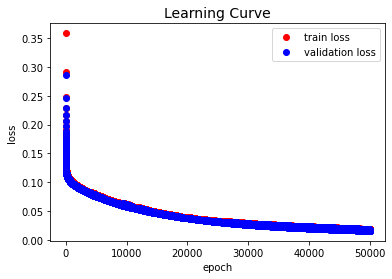

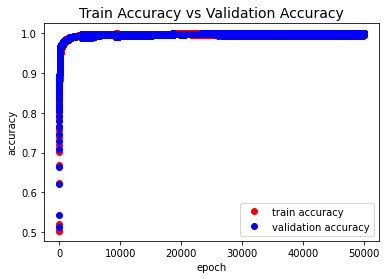

Test Predict Result:
[[1.        ]
 [0.17821741]
 [1.        ]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [1.        ]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [0.17821741]
 [1.        ]
 [0.17821741]
 [1.        ]
 [0.17821741]
 [1.        ]
 [0.17821741]
 [1.        ]
 [0.17821741]
 [1.        ]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [1.        ]
 [0.48315635]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [0.17821741]
 [0.17821741]
 [1.        ]
 [0.17821741]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [1.        ]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [0.17821741]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [1.        ]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [0.17821741]
 [0.17821741]
 [0.17821741]
 [0.17821741]
 [1.        ]
 [1.        ]
 [0.17821741]
 [0.17821741]
 [0.17821741]
 [0.99999836]
 [1.        ]
 [0.17821741]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.17821741]

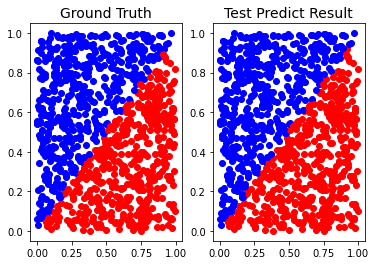

In [15]:
show_loss(loss_trains, loss_vals)
show_accuracy(accuracy_trains, accuracy_vals)
x_test, y_test = Data.generate_uniform_data(1000)
trainer.test(x_test, y_test)

### XOR

In [16]:
def get_X_data():
    points, labels = Data.generate_X_like_data(n = 11)
    x_train, x_val, x_test, y_train, y_val, y_test = points, points, points, labels, labels, labels

    print("shape of train data:", x_train.shape)
    print("shape of validation data:", x_val.shape)
    print("shape of test data:", x_test.shape)

    print("number of 1 in train data:", np.sum(y_train == 1))
    print("number of 0 in train data:", np.sum(y_train == 0))
    print("number of 1 in validation data:", np.sum(y_val == 1))
    print("number of 0 in validation data:", np.sum(y_val == 0))

    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = get_X_data()

shape of train data: (21, 2)
shape of validation data: (21, 2)
shape of test data: (21, 2)
number of 1 in train data: 10
number of 0 in train data: 11
number of 1 in validation data: 10
number of 0 in validation data: 11


In [21]:
INPUT_SIZE = 2
OUTPUT_SIZE = 1
HIDDEN_UNITS = ({
    "hidden_size": 3,
    "initializer": "normal",
    "bias": True
},{
    "hidden_size": 2,
    "initializer": "normal",
    "bias": True
},)
OUTPUT_INITIALIZER = "normal"
USE_OUTPUT_BIAS = True

EPOCH_SIZE = 50000
EARLY_STOPPING = False

OPTIMIZER = {
    "name": "sgd",
    "learning_rate": 1.0
}

LOSS_FUNCTION = "mse"

# Model
model_random_generator: np.random.Generator = np.random.default_rng(seed = 4321)
network = XORNetwork(INPUT_SIZE, OUTPUT_SIZE, model_random_generator, initializer = OUTPUT_INITIALIZER, bias = USE_OUTPUT_BIAS, hidden_units = HIDDEN_UNITS)
network.show_network()

trainer = Trainer(network, EPOCH_SIZE, loss_func_name = LOSS_FUNCTION, optimizer = OPTIMIZER, early_stop = EARLY_STOPPING)
loss_trains, loss_vals, accuracy_trains, accuracy_vals = trainer.train(x_train, x_val, y_train, y_val, shuffle = True)

Dense layer
shape of inputs: (*, 2)
shape of outputs: (*, 3)
shape of weights: (2, 3)
shape of bias: (3,)
--------------------------------------------------
ReLU
shape of activation: *
--------------------------------------------------
Dense layer
shape of inputs: (*, 3)
shape of outputs: (*, 2)
shape of weights: (3, 2)
shape of bias: (2,)
--------------------------------------------------
ReLU
shape of activation: *
--------------------------------------------------
Dense layer
shape of inputs: (*, 2)
shape of outputs: (*, 1)
shape of weights: (2, 1)
shape of bias: (1,)
--------------------------------------------------
Sigmoid
shape of activation: *
epoch: 1000, train loss: 0.010374535071904464, validation loss: 0.01036633404012833
epoch: 1000, train accuracy: 1.0, validation accuracy: 1.0



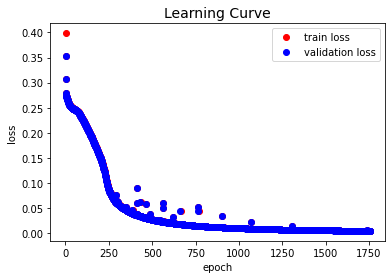

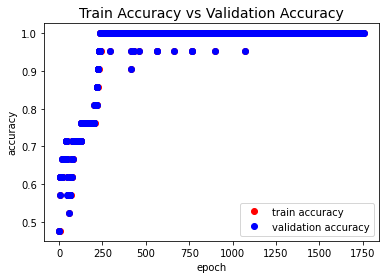

Test Predict Result:
[[0.09568547]
 [1.        ]
 [0.09568547]
 [1.        ]
 [0.09568547]
 [0.99999996]
 [0.09568547]
 [0.99996822]
 [0.09568547]
 [0.97577982]
 [0.09568547]
 [0.09568547]
 [0.9698026 ]
 [0.09568547]
 [0.97471359]
 [0.09568547]
 [0.97471359]
 [0.09568547]
 [0.97471359]
 [0.09568547]
 [0.97471359]]
Test Predict Accuracy: 1.0


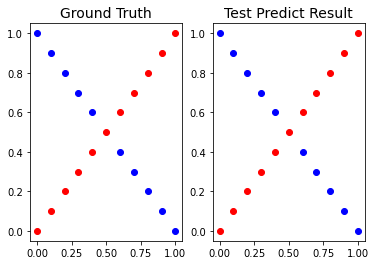

In [22]:
show_loss(loss_trains, loss_vals)
show_accuracy(accuracy_trains, accuracy_vals)
trainer.test(x_test, y_test)